# Settings

In [ ]:
from google.colab import  drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install timeshap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 848.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00


In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# data preprocessing
from keras.preprocessing import sequence
import random
# training
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.tree import DecisionTreeClassifier
# explainability
from captum.attr import IntegratedGradients
import timeshap
from timeshap.wrappers import TorchModelWrapper
import shap
# plot
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib import pyplot as plt
import seaborn as sns

# Train test split

In [ ]:
random.seed(42)

In [ ]:
id_list = list(df['admissionid'].unique())
SPLIT_SIZE = 0.2

In [ ]:
id_train, id_test_val = train_test_split(id_list, test_size = SPLIT_SIZE, random_state = 42) # train set is 80%)
print("train is %d" % len(id_train))
# remaining 20% split in halves as test and validation 10% and 10%
id_valid, id_test = train_test_split(id_test_val, test_size = 0.5, random_state = 42) # test 10% valid 10%
print("val and test are %d" %len(id_test))

train is 2247
val and test are 281


In [ ]:
train = df[df.admissionid.isin(id_train)].sort_values(by=['admissionid'])
test = df[df.admissionid.isin(id_test)].sort_values(by=['admissionid'], ignore_index = True)
validation = df[df.admissionid.isin(id_valid)].sort_values(by=['admissionid'])

test = test.sort_values(by=['admissionid', 'time'], ignore_index = True)
train = train.sort_values(by=['admissionid', 'time'], ignore_index = True)
validation = validation.sort_values(by=['admissionid', 'time'], ignore_index = True)

In [ ]:
train.columns

Index(['admissionid', 'time', 'steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'deceased', 'LOS', 'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation'],
      dtype='object')

In [ ]:
train.shape

(44526, 26)

# Extra data processing for LR and RF

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
# import torchtuples as tt

# from pycox.datasets import metabric
# from pycox.models import CoxPH
# from pycox.evaluation import EvalSurv

from collections import defaultdict


In [ ]:
'''
reshape dataset according to the requirements of survival analysis
reshape the dataset into -> each row represent one patient, each column represent one feature at one timestamp
nrow = patient_number, ncol = numeric_features * timestamp_number + static_features
'''

from keras.preprocessing import sequence
cols_numeric = ['admissionid', 'steroids', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation']
cols_static = ['admissionid', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'deceased']

# numeric features
print("drop timestamp")
X_train = train[cols_numeric]
X_validation = validation[cols_numeric]
X_test = test[cols_numeric]


print("reshape 2D dataframe to 3D Array, group by admissionid")
X_train = np.array(list(X_train.groupby(['admissionid'],as_index=False).apply(pd.DataFrame.to_numpy)))
print(X_train[0].shape)
X_validation = np.array(list(X_validation.groupby(['admissionid'],as_index=False).apply(pd.DataFrame.to_numpy)))
print(X_validation[0].shape)
X_test = np.array(list(X_test.groupby(['admissionid'],as_index=False).apply(pd.DataFrame.to_numpy)))
print(X_test[0].shape)


print("fill ragged part(missing value) of 3d array with 0") # to not affect imputed values
X_train = sequence.pad_sequences(X_train, maxlen=90)
X_train = X_train[:,:,1:] #delete admissionid
print(X_train.shape)
X_validation = sequence.pad_sequences(X_validation, maxlen=90)
X_validation = X_validation[:,:,1:] #delete admissionid
print(X_validation.shape)
X_test = sequence.pad_sequences(X_test, maxlen=90)
X_test = X_test[:,:,1:] #delete admissionid
print(X_test.shape)


print("flatten 3D array back to 2D array")
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))
print(X_train.shape)
nsamples, nx, ny = X_validation.shape
X_validation = X_validation.reshape((nsamples,nx*ny))
print(X_validation.shape)
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))
print(X_test.shape)

drop timestamp
reshape 2D dataframe to 3D Array, group by admissionid
(5, 18)
(3, 18)
(42, 18)
fill ragged part(missing value) of 3d array with 0
(2247, 90, 17)
(281, 90, 17)
(281, 90, 17)
flatten 3D array back to 2D array
(2247, 1530)
(281, 1530)
(281, 1530)


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# add static features

s_train = train[cols_static]
s_validation = validation[cols_static]
s_test = test[cols_static]

#extract datasets based on id_list -> train list

S_train = pd.DataFrame()
for id in s_train['admissionid'].unique():
  s_temp = s_train[s_train['admissionid'] == id].iloc[-1,1:]
  S_train = pd.concat([S_train, s_temp], axis=1)
S_train = S_train.T


S_validation = pd.DataFrame()
for id in s_validation['admissionid'].unique():
  s_temp = s_validation[s_validation['admissionid'] == id].iloc[-1,1:]
  S_validation = pd.concat([S_validation, s_temp], axis=1)
S_validation = S_validation.T


S_test = pd.DataFrame()
for id in s_test['admissionid'].unique():
  s_temp = s_test[s_test['admissionid'] == id].iloc[-1,1:]
  S_test = pd.concat([S_test, s_temp], axis=1)
S_test = S_test.T

In [ ]:
X_train = np.array(np.concatenate((X_train, S_train.iloc[:,:-1]), axis = 1))
X_validation = np.array(np.concatenate((X_validation, S_validation.iloc[:,:-1]), axis = 1))
X_test = np.array(np.concatenate((X_test, S_test.iloc[:,:-1]), axis = 1))

In [ ]:
print(X_train.shape) # 2247 * 1535
print(X_validation.shape) # 281 * 1535
print(X_test.shape) # 281 * 1535

(2247, 1535)
(281, 1535)
(281, 1535)


# LR

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
variables = ['steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation']

In [ ]:
get_target = lambda df: df['deceased'].values
y_train = get_target(S_train)
y_val = get_target(S_validation)
y_test = get_target(S_test)

In [ ]:
print("build LR")
model_LR1 = LogisticRegression(penalty = "l1", C = 0.1,fit_intercept = True, solver = 'saga', max_iter= 500,
                                  class_weight= 'balanced', random_state=42)

print("train LR")
model_LR1.fit(X_train, y_train)
# Make predictions
LR1_pred = model_LR1.predict(X_test)
# Predict probabilities on testing points
LR1_probs = model_LR1.predict_proba(X_test)[::,1]

build LR
train LR


The max_iter was reached which means the coef_ did not converge


In [ ]:
def performance (y_test, pred_probabilities):
    # performance
    fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities)
    # compute roc auc
    roc_auc = roc_auc_score(y_test, pred_probabilities, average = 'micro')
    # compute Precision_Recall curves
    precision, recall, _ = precision_recall_curve(y_test, pred_probabilities)
    # compute PR_AUC
    pr_auc = metrics.auc(recall, precision)
    # I add confusion matrix
    optimal_cut_off = round(thresholds[np.argmax(tpr - fpr)],4)
    a = np.where(pred_probabilities > optimal_cut_off, 1, 0)
    brier = round(metrics.brier_score_loss(y_test, pred_probabilities, sample_weight=None, pos_label=None),3)
    predictions = np.where(pred_probabilities > optimal_cut_off, 1, 0)

    print ("Area Under ROC Curve: %0.2f" % roc_auc  )
    #print ("Area Under PR Curve(AP): %0.2f" % pr_auc  )
    print("Brier score : {:.3f}".format(brier))
    #print('Accuracy for Classifier : {:.2f}'.format(accuracy_score(y_test, predictions)))
    #print('Cut off: ' + str(optimal_cut_off))
    matrix = metrics.confusion_matrix(y_test, a, labels=None, normalize=None)
    #print(str(matrix))

In [ ]:
performance(y_test,LR1_probs)

Area Under ROC Curve: 0.71
Brier score : 0.250


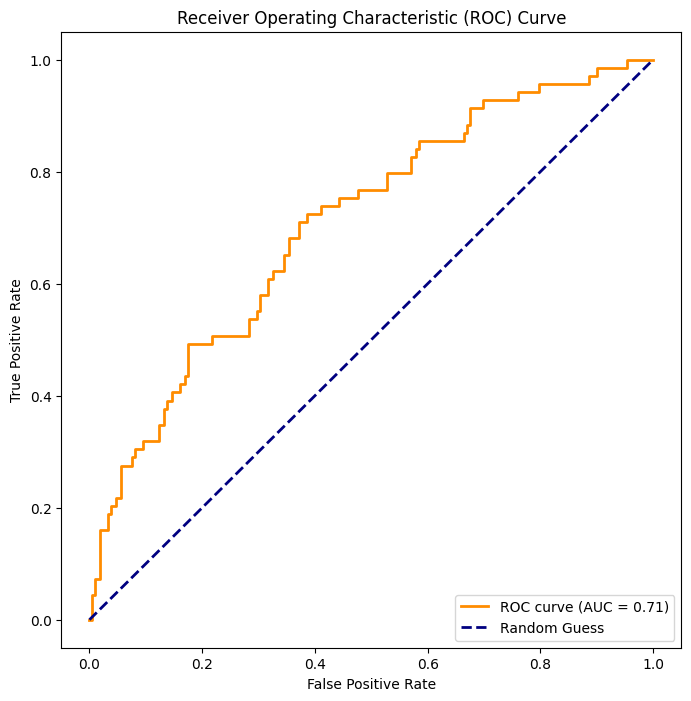

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

y_prob = model_LR1.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

feature importance

In [ ]:
timestamps = 90
# The estimated coefficients will all be around 1:
LRcoefs = model_LR1.coef_
#print(model_LR1.coef_)
#LRcoefsStd = LRcoefsStd.flatten()
LRcoefs = LRcoefs.flatten()
LRcoefs.shape # 1263= 90*14+3
# reshape to timestamps x features
logR_feat_dynamic = np.reshape(LRcoefs[:-5],(timestamps,-1))
logR_feat_dynamic = logR_feat_dynamic.mean(axis = 0)
logR_feat_static = LRcoefs[-5:]
logR_feat = np.concatenate((logR_feat_dynamic, logR_feat_static), axis = None)
print(logR_feat.shape)

(22,)


In [ ]:
logR_df =  pd.DataFrame(logR_feat, columns = ['Feature Importance'])
logR_df['Features'] = variables


import math
odds_ratio = []
for i in logR_feat:
    odds_ratio.append(math.exp(i))
logR_df['Odds ratio'] = odds_ratio

logR_df = logR_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

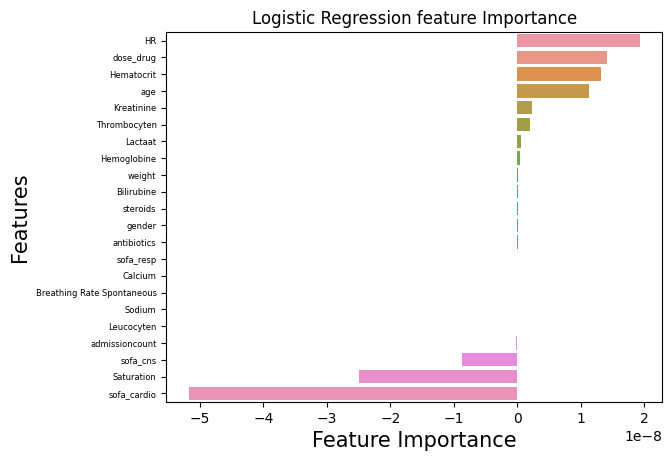

In [ ]:
ax = sns.barplot(x='Feature Importance', y='Features', data=logR_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('Logistic Regression feature Importance')
plt.savefig('LogR_feature_importance_sign.png', dpi = 300, bbox_inches='tight')

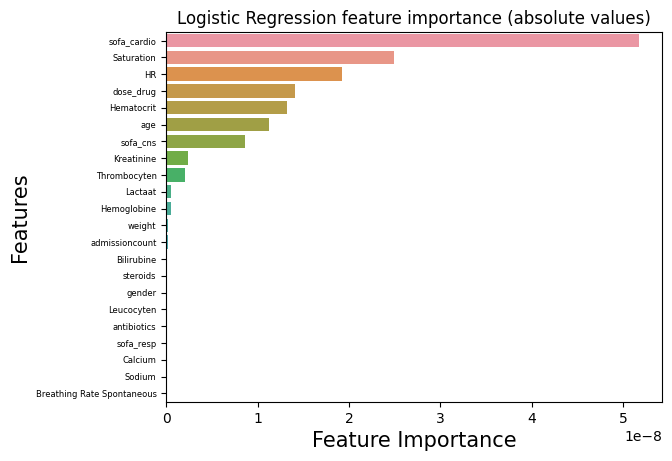

In [ ]:
logR_df['abs'] = abs(logR_df['Feature Importance'])
logR_df = logR_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
ax = sns.barplot(x='abs', y='Features', data=logR_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('Logistic Regression feature importance (absolute values)')
plt.savefig('LogR_feature_importance_absolute.png', dpi = 300, bbox_inches='tight')

### shap

In [ ]:
import shap

In [ ]:
# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP
lr_explainer = shap.LinearExplainer(model_LR1,X_test, feature_perturbation="interventional")
lr_shap_values = lr_explainer.shap_values(X_test)

In [ ]:
def mean_over_timestamps(n, shap_values, X):
    a = []
    b = []
    i = 0
    f = 0
    # first calculate dynamic features
    while f < 18: # num features
        temp_a = 0
        temp_b = 0
        i = i + f
        counter = 0
        while counter < 90: # max iteration
            temp_a += shap_values[n][i]
            temp_b += X[n][i]
            i += 18
            counter += 1
            # ignore completely padded timestamps
            if np.any(X[n][i:i+18]):
                continue
            else:
                break
        a.append(temp_a/counter) #mean shap
        b.append(temp_b/counter) #mean feature
        i = 0
        f += 1
    # add static features
    a.extend(shap_values[n][-5:])
    b.extend(X[n][-5:])
    a = np.array(a).reshape((1,-1))
    b = np.array(b).reshape((1,-1))
    return a, b

In [ ]:
# for the first istance
lr_shap_mean, lr_X_mean = mean_over_timestamps(0, lr_shap_values, X_test)
n = 1
while n < X_test.shape[0]:
    a,b = mean_over_timestamps(n, lr_shap_values, X_test)
    n += 1
    lr_shap_mean = np.concatenate((lr_shap_mean, a), axis = 0)
    lr_X_mean = np.concatenate((lr_X_mean, b), axis = 0)
print(lr_shap_mean.shape)
print(lr_X_mean.shape)

(281, 23)
(281, 23)


In [ ]:
lr_X_mean = pd.DataFrame(lr_X_mean, columns= variables)

In [ ]:
single_shap_lr = lr_shap_mean[2,:]
single_X_lr = lr_X_mean[2:3]
# visualize single prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(lr_explainer.expected_value, single_shap_lr, single_X_lr)

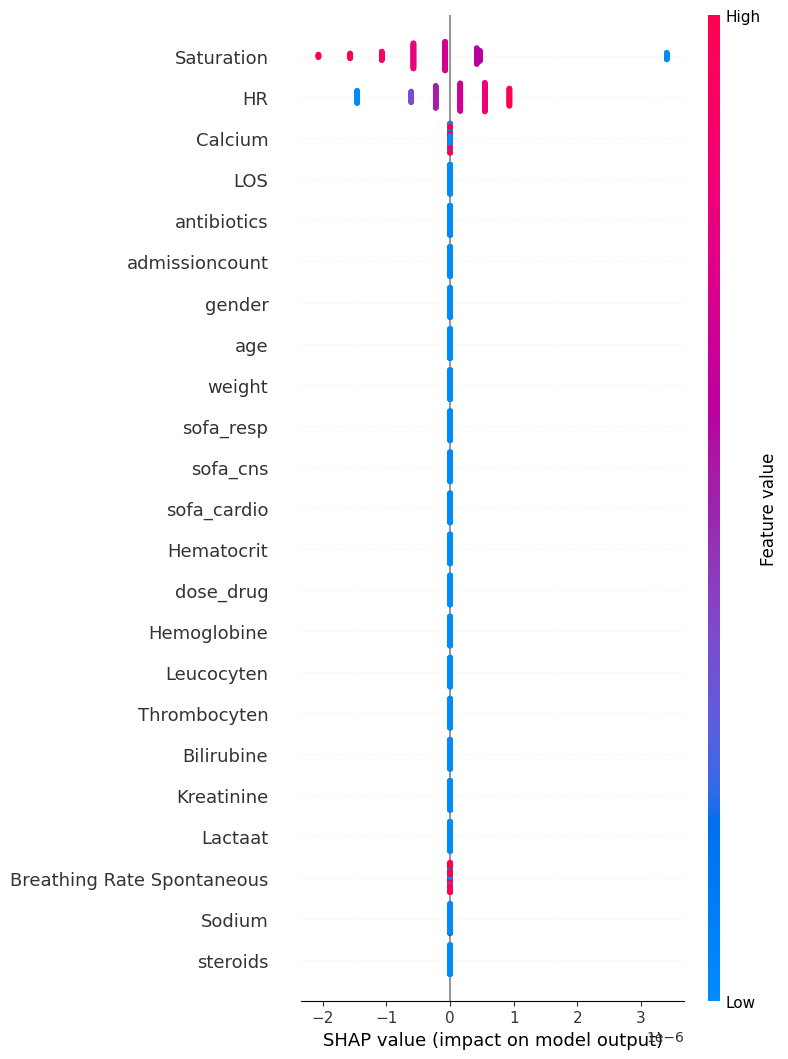

<Figure size 640x480 with 0 Axes>

In [ ]:
# summarize the effects of all the features
shap.summary_plot(lr_shap_mean, lr_X_mean,max_display=X_test.shape[1])
plt.savefig('LogR_shap summary.png', dpi = 300, bbox_inches='tight')

# Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
print("build RF")
# building RF (default parameters)
rf_model = RandomForestClassifier(n_estimators=700,criterion='gini',max_depth=40,min_samples_split=10,min_samples_leaf=2,
                                  min_weight_fraction_leaf=0.0,max_features='auto',max_leaf_nodes=None,
                                  bootstrap=False,oob_score=False,n_jobs=None,random_state=None,verbose=0,warm_start=False,
                                  class_weight=None,ccp_alpha=0.0,max_samples=None)


print("train RF")
# train RF
rf_model.fit(X_train, y_train)

print("predictions")
#Make predictions
RF_pred = rf_model.predict(X_test)
RF_probs = rf_model.predict_proba(X_test)[::,1] # probability of class 1

build RF
train RF


`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


predictions


In [ ]:
performance(y_test,RF_probs)

Area Under ROC Curve: 0.88
Brier score : 0.113


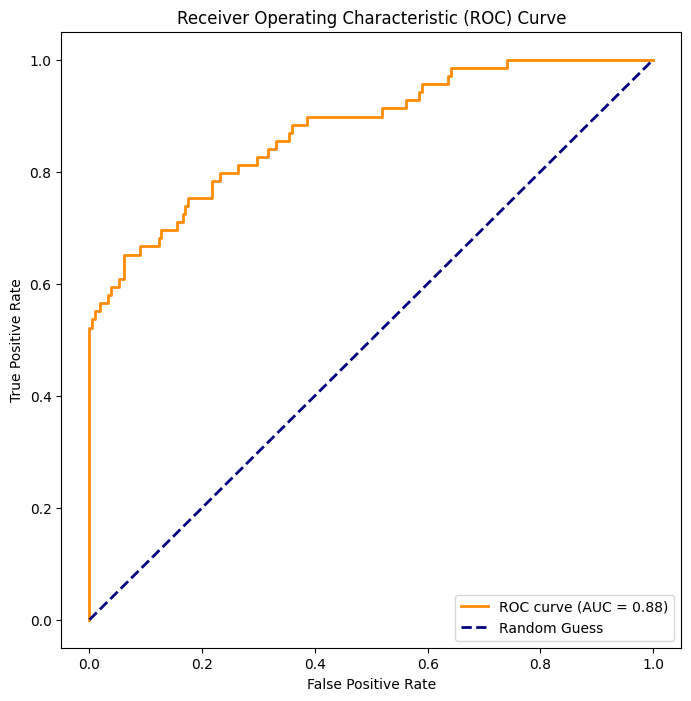

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, RF_probs)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# reshape to timestamps x features
rf_feat = rf_model.feature_importances_
print(rf_feat.shape)
rf_feat_dynamic = np.reshape(rf_feat[:-5],(timestamps,-1))
# sum the feature importance by feature
rf_feat_dynamic = rf_feat_dynamic.sum(axis = 0)
# get feature importance of static features
rf_feat_static = rf_feat[-5:]
rf_feat = np.concatenate((rf_feat_dynamic, rf_feat_static), axis = None)

print(rf_feat.shape)

(1535,)
(22,)


In [ ]:
rf_feat.sum()

0.9999999999999999

In [ ]:
rf_df =  pd.DataFrame(rf_feat, columns = ['Feature Importance'])
rf_df['Features'] = variables
rf_df = rf_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

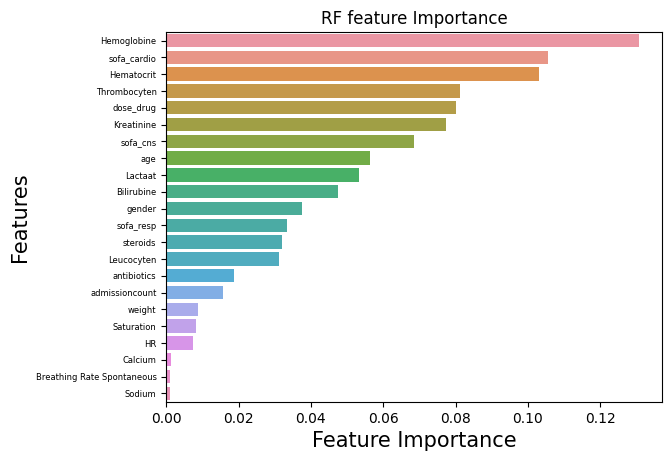

In [ ]:
ax = sns.barplot(x='Feature Importance', y='Features', data=rf_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('RF feature Importance')
plt.savefig('RF_feature_importance.png', dpi = 300, bbox_inches='tight')

In [ ]:
# load JS visualization code to notebook
shap.initjs()

rf_explainer = shap.TreeExplainer(rf_model)
rf_shap_values = rf_explainer.shap_values(X_test)

### shap

In [ ]:
def mean_over_timestamps_rf(n, shap_values, X):
    a = []
    b = []
    i = 0
    f = 0
    while f < 11:
        temp_a = 0 # sum of a feature shap
        temp_b = 0 # sum of feature value
        i = i + f # ith column, fth feature
        counter = 0 # current timestamp
        while counter < 90: # max iteration
            temp_a += shap_values[n][i]
            temp_b += X[n][i]
            i += 11
            counter += 1
            # decide if it is padded data
            if np.any(X[n][i:i+11]):
                continue
            else:
                break
        a.append(temp_a/counter) #mean shap
        b.append(temp_b/counter) #mean feature
        i = 0
        f += 1
    # add static features
    a.extend(shap_values[n][-3:])
    b.extend(X[n][-3:])
    a = np.array(a).reshape((1,-1))
    b = np.array(b).reshape((1,-1))
    return a, b

In [ ]:
# for the first istance
rf_shap_mean, rf_X_mean = mean_over_timestamps(0,rf_shap_values[1],X_test)
n = 1
while n < X_test.shape[0]:
    a,b = mean_over_timestamps(n, rf_shap_values[1],X_test)
    n+=1
    rf_shap_mean = np.concatenate((rf_shap_mean, a), axis=0)
    rf_X_mean = np.concatenate((rf_X_mean, b), axis=0)
rf_X_mean = pd.DataFrame(rf_X_mean, columns= variables)

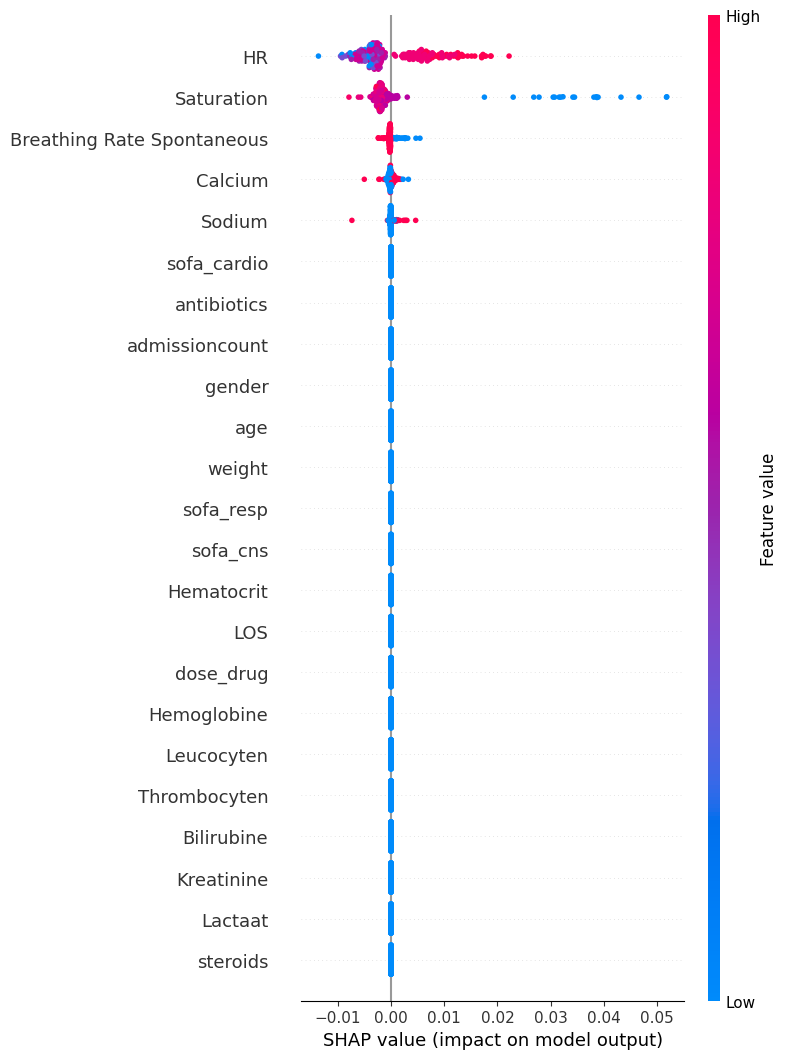

In [ ]:
shap.summary_plot(rf_shap_mean, rf_X_mean, max_display=X_test.shape[1])

# LSTM

## Extra data processing for LSTM

In [ ]:
'''
reshape dataset according to the requirements of survival analysis
reshape the dataset into -> each row represent one patient, each column represent one feature at one timestamp
nrow = patient_number, ncol = numeric_features * timestamp_number + static_features
'''

col_x = ['admissionid', 'steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation']
col_y = ['admissionid', "deceased"]


# numeric features
print("drop timestamp")
X_train = train[col_x]
y_train = train[col_y]
X_validation = validation[col_x]
y_validation = validation[col_y]
X_test = test[col_x]
y_test = test[col_y]


print("reshape 2D dataframe to 3D Array, group by admissionid")
X_train = np.array(list(X_train.groupby(['admissionid'],as_index=False).apply(pd.DataFrame.to_numpy)))
print(X_train[0].shape)
X_validation = np.array(list(X_validation.groupby(['admissionid'],as_index=False).apply(pd.DataFrame.to_numpy)))
print(X_validation[0].shape)
X_test = np.array(list(X_test.groupby(['admissionid'],as_index=False).apply(pd.DataFrame.to_numpy)))
print(X_test[0].shape)


print("fill ragged part(missing value) of 3d array with 0")
X_train = sequence.pad_sequences(X_train, dtype='float32', maxlen=90)
X_train = X_train[:,:,1:] #delete admissionid
print(X_train.shape)
X_validation = sequence.pad_sequences(X_validation, dtype='float32', maxlen=90)
X_validation = X_validation[:,:,1:] #delete admissionid
print(X_validation.shape)
X_test = sequence.pad_sequences(X_test, dtype='float32', maxlen=90)
X_test = X_test[:,:,1:] #delete admissionid
print(X_test.shape)

drop timestamp
reshape 2D dataframe to 3D Array, group by admissionid
(5, 23)
(3, 23)
(42, 23)
fill ragged part(missing value) of 3d array with 0
(2247, 90, 22)
(281, 90, 22)
(281, 90, 22)


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# pytorch
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
X_valid = torch.from_numpy(X_validation).type(torch.FloatTensor)
X_test = torch.from_numpy(X_test).type(torch.FloatTensor)

In [ ]:
y_train = np.array(list(y_train.groupby(['admissionid'],as_index=False).apply(pd.DataFrame.to_numpy)))
print(y_train[0].shape)
y_valid = np.array(list(y_validation.groupby(['admissionid'],as_index=False).apply(pd.DataFrame.to_numpy)))
y_test = np.array(list(y_test.groupby(['admissionid'],as_index=False).apply(pd.DataFrame.to_numpy)))

print("fill ragged part(missing value) of 3d array with 0")
y_train = sequence.pad_sequences(y_train, dtype='float32', maxlen=90)
y_train = y_train[:,:,1:] #delete admissionid
print(y_train.shape)
y_valid = sequence.pad_sequences(y_valid, dtype='float32', maxlen=90)
y_valid = y_valid[:,:,1:] #delete admissionid
print(y_valid.shape)
y_test = sequence.pad_sequences(y_test, dtype='float32', maxlen=90)
y_test = y_test[:,:,1:] #delete admissionid
print(y_test.shape)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(5, 2)
fill ragged part(missing value) of 3d array with 0
(2247, 90, 1)
(281, 90, 1)
(281, 90, 1)


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# pytorch
y_train = torch.from_numpy(y_train).type(torch.FloatTensor)
y_valid = torch.from_numpy(y_valid).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.FloatTensor)

In [ ]:
X_train.dtype

torch.float32

Tensorflow processing

In [ ]:
col_x = ['admissionid', 'time','steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation']
col_y = ['admissionid', 'time', "deceased"]

x_train = train[col_x]
y_train = train[col_y]
x_validation = validation[col_x]
y_validation = validation[col_y]
x_test = test[col_x]
y_test = test[col_y]

x_train.set_index(['admissionid','time'], append=True, inplace=True)
y_train.set_index(['admissionid','time'], append=True, inplace=True)
x_validation.set_index(['admissionid','time'], append=True, inplace=True)
y_validation.set_index(['admissionid','time'], append=True, inplace=True)
x_test.set_index(['admissionid','time'], append=True, inplace=True)
y_test.set_index(['admissionid','time'], append=True, inplace=True)

In [ ]:
from tensorflow.keras.preprocessing import sequence

# max number of sequence length
maxlen = 90 # 720 hours max LOS divided by 8 hours timestep

# get a list of unique patient encounter IDs
teId = x_train.index.levels[1]
veId = x_validation.index.levels[1]
teeId = x_test.index.levels[1]

X_train = [x_train.loc[(slice(None), patient), :].values for patient in teId]
y_train = [y_train.loc[(slice(None), patient), :].values for patient in teId]

X_train = sequence.pad_sequences(X_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

# repeat for the validation data

X_valid = [x_validation.loc[(slice(None), patient), :].values for patient in veId]
y_valid = [y_validation.loc[(slice(None), patient), :].values for patient in veId]

X_valid = sequence.pad_sequences(X_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_valid = sequence.pad_sequences(y_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

X_test = [x_test.loc[(slice(None), patient), :].values for patient in teeId]
y_test = [y_test.loc[(slice(None), patient), :].values for patient in teeId]

X_test = sequence.pad_sequences(X_test, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_test = sequence.pad_sequences(y_test, dtype='float32', maxlen=maxlen, padding='post', truncating='post')


In [ ]:
# print the shape of the array which will be used by the network
# the shape is of the form (# of encounters, length of sequence, # of features)
print("X_train shape: %s | y_train shape: %s" % (str(X_train.shape), str(y_train.shape)))
print("X_valid shape: %s | y_valid shape: %s" % (str(X_valid.shape), str(y_valid.shape)))
print("X_test shape: %s | y_test shape: %s" % (str(X_test.shape), str(y_test.shape)))

X_train shape: (2247, 90, 22) | y_train shape: (2247, 90, 1)
X_valid shape: (281, 90, 22) | y_valid shape: (281, 90, 1)
X_test shape: (281, 90, 22) | y_test shape: (281, 90, 1)


## Tensorflow model

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Masking
from tensorflow.keras.optimizers import RMSprop

# construct inputs
x = Input((90, 22) , name='input')
mask = Masking(0, name='input_masked')(x)

# stack LSTMs
lstm_kwargs = {'dropout': 0.25, 'recurrent_dropout': 0.3, 'return_sequences': True}
lstm1 = LSTM(90, name='lstm1', **lstm_kwargs)(mask)

# output: sigmoid layer
output = TimeDistributed(Dense(1, activation='sigmoid'), name='output')(lstm1)
model = Model(inputs=x, outputs=output)

# compile model
optimizer = RMSprop(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# print layer shapes and model parameters
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 90, 22)]          0         
                                                                 
 input_masked (Masking)      (None, 90, 22)            0         
                                                                 
 lstm1 (LSTM)                (None, 90, 90)            40680     
                                                                 
 output (TimeDistributed)    (None, 90, 1)             91        
                                                                 
Total params: 40771 (159.26 KB)
Trainable params: 40771 (159.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/MAM12A project/models_LSTM_ana/LSTM_checkpoint_12-12-2023')

## Pytorch model

In order to apply integrated gradients that is only compatible with pytorch models, we need to transfer the weights and construct a pytorch LSTM model with the same architecture

In [ ]:
model.variables

[<tf.Variable 'lstm1/lstm_cell/kernel:0' shape=(22, 512) dtype=float32, numpy=
 array([[ 0.07633473, -0.00833625,  0.00144513, ...,  0.03245289,
         -0.04590461, -0.01434301],
        [ 0.08580396, -0.02612481, -0.03141242, ...,  0.0334085 ,
          0.03113089, -0.03152132],
        [-0.06625424, -0.02892994, -0.01679991, ...,  0.00590452,
         -0.05145267,  0.08593193],
        ...,
        [ 0.01205638, -0.07686266, -0.10674724, ..., -0.11308215,
          0.06765342, -0.05295902],
        [ 0.00705936, -0.16253893, -0.13131903, ...,  0.11134064,
         -0.10465737, -0.03615802],
        [-0.00599461, -0.11542754, -0.11326694, ..., -0.04165886,
          0.10222466, -0.06720079]], dtype=float32)>,
 <tf.Variable 'lstm1/lstm_cell/recurrent_kernel:0' shape=(128, 512) dtype=float32, numpy=
 array([[ 0.03451016, -0.05710601,  0.06703432, ...,  0.02968078,
         -0.03358766, -0.01704149],
        [-0.01335673, -0.06591606,  0.05348733, ..., -0.09500433,
          0.01953636

In [ ]:
import torch.nn.functional as F

class CustomLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.25):
        super(CustomLSTM, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            dropout=dropout,
            batch_first=True,
            bidirectional=False,  # Adjust if needed
        )

    def forward(self, x):
        x = F.dropout(x, p=self.lstm.dropout, training=self.training)
        lstm_out, _ = self.lstm(x)
        return lstm_out

class CustomModel(nn.Module):
    def __init__(self, input_size):
        super(CustomModel, self).__init__()

        self.masking = nn.Identity()
        self.lstm1 = CustomLSTM(input_size, 128, dropout=0.25)
        self.dense = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.masking(x)
        lstm_out = self.lstm1(x)
        dense_out = self.dense(lstm_out)
        output = self.sigmoid(dense_out)
        return output[:,-1,:]


input_size = 22
pytorch_model = CustomModel(input_size)

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1


In [ ]:
# Transfer weights from TensorFlow to PyTorch
with torch.no_grad():
    pytorch_model.lstm1.lstm.weight_ih_l0 = nn.Parameter(torch.tensor(np.transpose(model.get_layer('lstm1').get_weights()[0])))
    pytorch_model.lstm1.lstm.weight_hh_l0 = nn.Parameter(torch.tensor(np.transpose(model.get_layer('lstm1').get_weights()[1])))
    pytorch_model.lstm1.lstm.bias_ih_l0 = nn.Parameter(torch.tensor(model.get_layer('lstm1').get_weights()[2]))

    hidden_size = 128
    num_layers = 1
    bias_hh_l0 = np.zeros((4 * hidden_size * num_layers,))
    pytorch_model.lstm1.lstm.bias_hh_l0 = nn.Parameter(torch.tensor(bias_hh_l0, dtype=torch.float32))

    pytorch_model.dense.weight = nn.Parameter(torch.tensor(np.transpose(model.get_layer('output').get_weights()[0])))
    pytorch_model.dense.bias = nn.Parameter(torch.tensor(model.get_layer('output').get_weights()[1]))

print("Weights transferred successfully!")

Weights transferred successfully!


In [ ]:
pytorch_model

CustomModel(
  (masking): Identity()
  (lstm1): CustomLSTM(
    (lstm): LSTM(22, 128, batch_first=True, dropout=0.25)
  )
  (dense): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# save model
model_path = '/content/drive/MyDrive/Colab Notebooks/MAM12A project/pytorch_model/pytorch_model.pth'
torch.save(pytorch_model.state_dict(), model_path)

In [ ]:
# load model
pytorch_model = CustomModel(input_size)

model_path = '/content/drive/MyDrive/Colab Notebooks/MAM12A project/pytorch_model/pytorch_model.pth'
model_state_dict = torch.load(model_path)

pytorch_model.load_state_dict(model_state_dict)

<All keys matched successfully>

Performance on full X_test where it has no batching: is padded to max dimentions. 

Area Under ROC Curve: 0.83
Brier score : 0.264


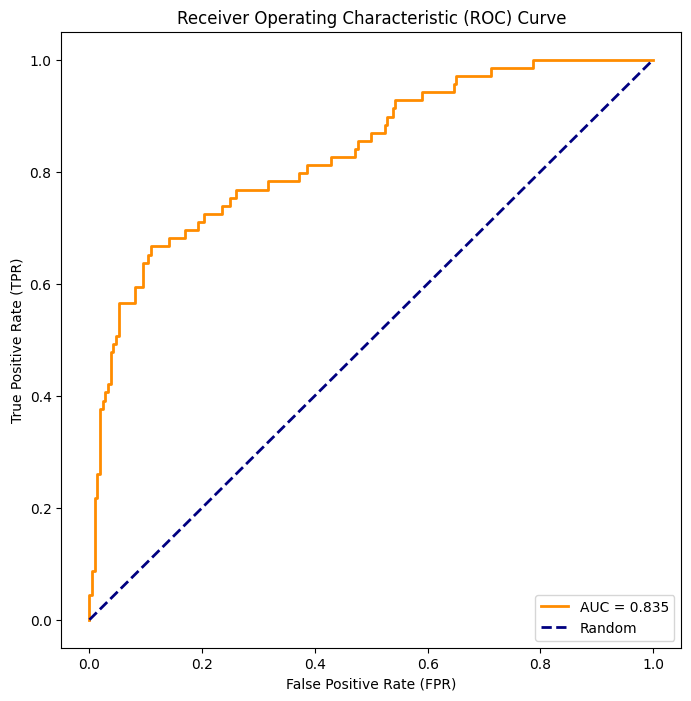

In [ ]:
logits = pytorch_model(X_test)
pred = torch.nn.Sigmoid() (logits)
pred = pred.reshape(-1,1).detach().numpy()

y_true = y_test[:,-1,:].reshape(-1,1).detach().numpy()
print("Performance on full X_test where it has no batching: is padded to max dimentions. \n")
print ("Area Under ROC Curve: %0.2f" % roc_auc_score(y_true, pred, average = 'micro')  )
brier = round(metrics.brier_score_loss(y_true, pred, sample_weight=None, pos_label=None),3)
print("Brier score : {:.3f}".format(brier))

fpr, tpr, thresholds = roc_curve(y_true, pred)

# Calculate Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
unique_values, counts = np.unique(y_true, return_counts=True)
counts

array([212,  69])

## Subgroups

### correct vs incorrect

In [ ]:
# get prediction
y_test_t = y_test[:,-1,:]
preds_t = pred

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_t, preds_t)

# Iterate through thresholds and select the one that maximizes F1 score for each sample
selected_thresholds = []

f1_scores = [f1_score(y_test_t, (preds_t >= threshold).astype(int)) for threshold in thresholds]
best_threshold_index = f1_scores.index(max(f1_scores))
selected_threshold = thresholds[best_threshold_index]

# Extract predicted labels at selected thresholds
predicted_labels_at_selected_threshold = (preds_t >= selected_threshold).astype(int)

unique_values, counts = np.unique(predicted_labels_at_selected_threshold, return_counts=True)

print(f"Selected Threshold = {selected_threshold:.4f}, Predicted Label Counts = {counts}")

Selected Threshold = 0.5586, Predicted Label Counts = [212  69]


In [ ]:
# get index for correct predictions
correct_indices = [i for i, (true, pred) in enumerate(zip(y_true, predicted_labels_at_selected_threshold)) if true == pred]
correct_indices = torch.tensor(correct_indices)
X_test_correct = X_test[correct_indices]
print(X_test_correct.shape)

torch.Size([235, 90, 22])


In [ ]:
# get index for incorrect predictions
incorrect_indices = [i for i, (true, pred) in enumerate(zip(y_true, predicted_labels_at_selected_threshold)) if true != pred]
incorrect_indices = torch.tensor(incorrect_indices)
X_test_incorrect = X_test[incorrect_indices]
print(X_test_incorrect.shape)

torch.Size([46, 90, 22])


### age group

In [ ]:
young_id = test[test['age']<25]['admissionid'].unique()
young_indices = torch.tensor([sorted(id_test).index(young_id) for young_id in young_id])
X_test_young = X_test[young_indices]
print(X_test_young.shape)

torch.Size([30, 90, 22])


In [ ]:
middleage_id = test[(test['age']>25) & (test['age']<60)]['admissionid'].unique()
middleage_indices = torch.tensor([sorted(id_test).index(middleage_id) for middleage_id in middleage_id])
X_test_middleage = X_test[middleage_indices]
print(X_test_middleage.shape)

torch.Size([78, 90, 22])


In [ ]:
old_id = test[test['age']>60]['admissionid'].unique()
old_indices = torch.tensor([sorted(id_test).index(old_id) for old_id in old_id])
X_test_old = X_test[old_indices]
print(X_test_old.shape)

torch.Size([108, 90, 22])


### steroid

In [ ]:
steroid_id = test[test['steroids']==1]['admissionid'].unique()
steroid_indices = torch.tensor([sorted(id_test).index(steroid_id) for steroid_id in steroid_id])
X_test_steroid = X_test[steroid_indices]
print(X_test_steroid.shape)

torch.Size([111, 90, 22])


In [ ]:
nosteroid_id = [item for item in test['admissionid'].unique() if item not in steroid_id]
# nosteroid_id = test[test['steroids']==0]['admissionid'].unique()
nosteroid_indices = torch.tensor([sorted(id_test).index(nosteroid_id) for nosteroid_id in nosteroid_id])
X_test_nosteroid = X_test[nosteroid_indices]
print(X_test_nosteroid.shape)

torch.Size([170, 90, 22])


### quick sofa at admission

In [ ]:
highsofa_id = [
    id for id in test['admissionid'].unique() if
    (test[test['admissionid'] == id].iloc[0]['sofa_resp'] > 1) or
    (test[test['admissionid'] == id].iloc[0]['sofa_cns'] > 1) or
    (test[test['admissionid'] == id].iloc[0]['sofa_cardio'] > 1)
]
highsofa_indices = torch.tensor([sorted(id_test).index(highsofa_id) for highsofa_id in highsofa_id])
X_test_highsofa = X_test[highsofa_indices]
print(X_test_highsofa.shape)

torch.Size([234, 90, 22])


In [ ]:
lowsofa_id = [
    id for id in test['admissionid'].unique() if
    (test[test['admissionid'] == id].iloc[0]['sofa_resp'] == 0) and
    (test[test['admissionid'] == id].iloc[0]['sofa_cns'] == 0) and
    (test[test['admissionid'] == id].iloc[0]['sofa_cardio'] == 0)
]
lowsofa_indices = torch.tensor([sorted(id_test).index(lowsofa_id) for lowsofa_id in lowsofa_id])
X_test_lowsofa = X_test[lowsofa_indices]
print(X_test_lowsofa.shape)

torch.Size([21, 90, 22])


## integrated gradients

In [ ]:
features = 22
timestamps = 720
feature_names = ['steroids', 'antibiotics', 'admissioncount', 'gender', 'age', 'weight',
       'sofa_resp', 'sofa_cns', 'sofa_cardio', 'dose_drug', 'Hematocrit',
       'Hemoglobine', 'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine',
       'Lactaat', 'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR',
       'Saturation']

In [ ]:
def visualize_feature_importances(feature_names, importances, title="LSTM Average Feature Importances", axis_title="Features"):
    print(title)
    i = 0
    while i < features:
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
        i +=1
    x_pos = (np.arange(len(feature_names)))

ig = IntegratedGradients(pytorch_model)

correct

LSTM Average Feature Importances
steroids :  -0.000
antibiotics :  0.000
admissioncount :  -0.000
gender :  0.000
age :  -0.002
weight :  0.003
sofa_resp :  -0.000
sofa_cns :  0.000
sofa_cardio :  -0.000
dose_drug :  -0.001
Hematocrit :  0.000
Hemoglobine :  0.000
Leucocyten :  -0.000
Thrombocyten :  0.003
Bilirubine :  -0.000
Kreatinine :  -0.001
Lactaat :  -0.000
Breathing Rate Spontaneous :  0.000
Sodium :  0.000
Calcium :  -0.000
HR :  0.000
Saturation :  0.001


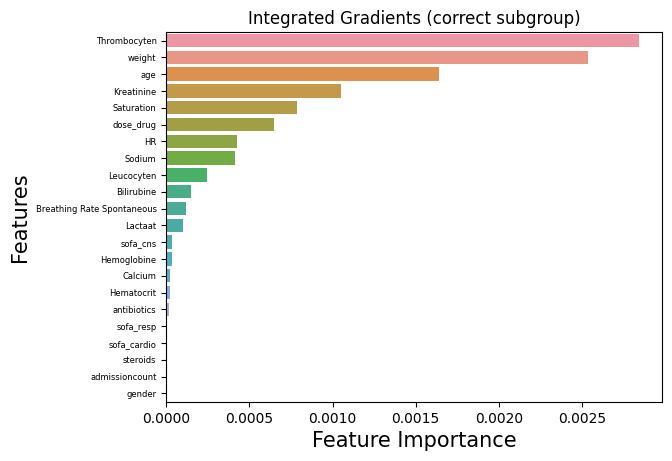

In [ ]:
X_test_correct.requires_grad_()

# use mean for features as baseline
baseline = torch.mean(X_test_correct, dim=(0, 1), keepdim=True)

attr = ig.attribute(X_test_correct, baseline, target=1, return_convergence_delta=False)
attr = attr.detach().numpy()
attr_flat = attr.reshape(-1,22)
importances = np.mean(attr_flat, axis=0)

visualize_feature_importances(feature_names, importances)

lstm_df =  pd.DataFrame(importances, columns = ['Feature Importance'])
lstm_df['Features'] = feature_names
lstm_df = lstm_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

# absolute
lstm_df['abs'] = abs(lstm_df['Feature Importance'])
lstm_df = lstm_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
ax = sns.barplot(x='abs', y='Features', data=lstm_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('Integrated Gradients (correct subgroup)')
plt.savefig('LSTM_feature_importance_absolute.png', dpi = 300, bbox_inches='tight')

incorrect

LSTM Average Feature Importances
steroids :  -0.000
antibiotics :  0.000
admissioncount :  -0.000
gender :  -0.000
age :  -0.002
weight :  0.003
sofa_resp :  -0.000
sofa_cns :  0.000
sofa_cardio :  -0.000
dose_drug :  -0.001
Hematocrit :  0.000
Hemoglobine :  0.000
Leucocyten :  -0.000
Thrombocyten :  0.003
Bilirubine :  -0.001
Kreatinine :  -0.001
Lactaat :  -0.000
Breathing Rate Spontaneous :  0.000
Sodium :  0.001
Calcium :  -0.000
HR :  0.000
Saturation :  0.001


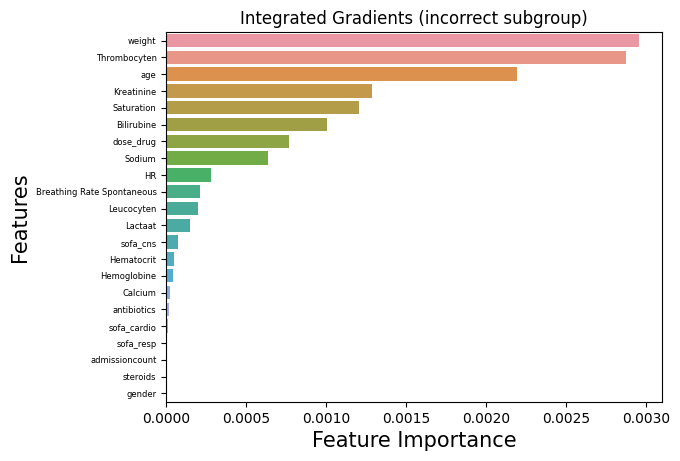

In [ ]:
X_test_incorrect.requires_grad_()

# use mean for features as baseline
baseline = torch.mean(X_test_incorrect, dim=(0, 1), keepdim=True)

attr = ig.attribute(X_test_incorrect, baseline, target=1, return_convergence_delta=False)
attr = attr.detach().numpy()
attr_flat = attr.reshape(-1,22)
importances = np.mean(attr_flat, axis=0)

visualize_feature_importances(feature_names, importances)

lstm_df =  pd.DataFrame(importances, columns = ['Feature Importance'])
lstm_df['Features'] = feature_names
lstm_df = lstm_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

# absolute
lstm_df['abs'] = abs(lstm_df['Feature Importance'])
lstm_df = lstm_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
ax = sns.barplot(x='abs', y='Features', data=lstm_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('Integrated Gradients (incorrect subgroup)')
plt.savefig('LSTM_feature_importance_absolute.png', dpi = 300, bbox_inches='tight')

young

LSTM Average Feature Importances
steroids :  -0.000
antibiotics :  0.000
admissioncount :  -0.000
gender :  -0.000
age :  -0.000
weight :  0.002
sofa_resp :  -0.000
sofa_cns :  0.000
sofa_cardio :  -0.000
dose_drug :  -0.000
Hematocrit :  0.000
Hemoglobine :  0.000
Leucocyten :  -0.000
Thrombocyten :  0.002
Bilirubine :  -0.000
Kreatinine :  -0.000
Lactaat :  -0.000
Breathing Rate Spontaneous :  0.000
Sodium :  0.000
Calcium :  -0.000
HR :  0.000
Saturation :  0.001


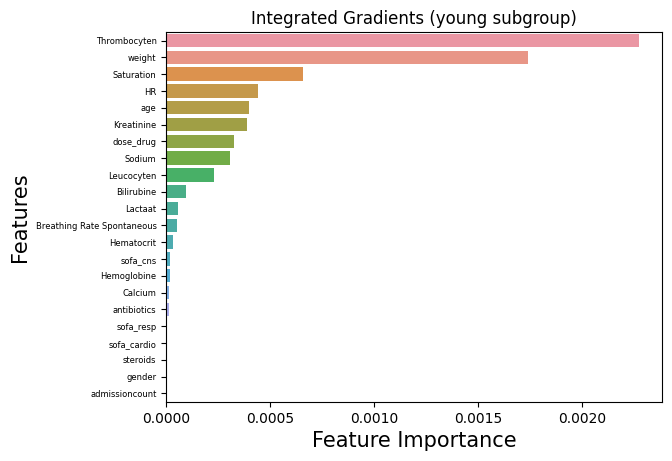

In [ ]:
X_test_young.requires_grad_()

# use mean for features as baseline
baseline = torch.mean(X_test_young, dim=(0, 1), keepdim=True)

attr = ig.attribute(X_test_young, baseline, target=1, return_convergence_delta=False)
attr = attr.detach().numpy()
attr_flat = attr.reshape(-1,22)
importances = np.mean(attr_flat, axis=0)

visualize_feature_importances(feature_names, importances)

lstm_df =  pd.DataFrame(importances, columns = ['Feature Importance'])
lstm_df['Features'] = feature_names
lstm_df = lstm_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

# absolute
lstm_df['abs'] = abs(lstm_df['Feature Importance'])
lstm_df = lstm_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
ax = sns.barplot(x='abs', y='Features', data=lstm_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('Integrated Gradients (young subgroup)')
plt.savefig('LSTM_feature_importance_absolute.png', dpi = 300, bbox_inches='tight')

middleage

LSTM Average Feature Importances
steroids :  -0.000
antibiotics :  0.000
admissioncount :  -0.000
gender :  0.000
age :  -0.001
weight :  0.003
sofa_resp :  -0.000
sofa_cns :  0.000
sofa_cardio :  -0.000
dose_drug :  -0.000
Hematocrit :  0.000
Hemoglobine :  0.000
Leucocyten :  -0.000
Thrombocyten :  0.003
Bilirubine :  -0.000
Kreatinine :  -0.001
Lactaat :  -0.000
Breathing Rate Spontaneous :  0.000
Sodium :  0.000
Calcium :  -0.000
HR :  0.000
Saturation :  0.001


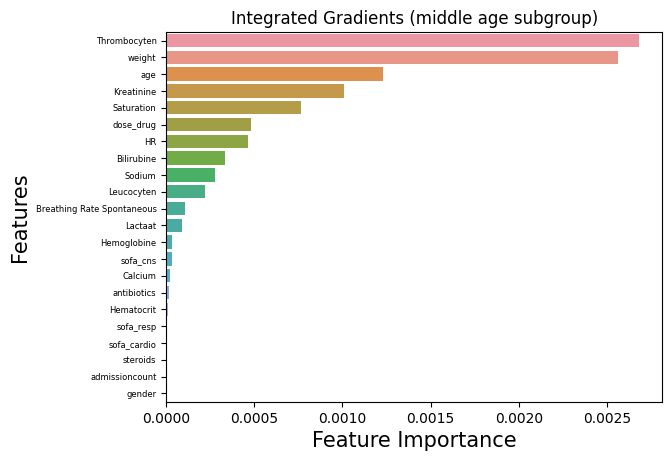

In [ ]:
X_test_middleage.requires_grad_()

# use mean for features as baseline
baseline = torch.mean(X_test_middleage, dim=(0, 1), keepdim=True)

attr = ig.attribute(X_test_middleage, baseline, target=1, return_convergence_delta=False)
attr = attr.detach().numpy()
attr_flat = attr.reshape(-1,22)
importances = np.mean(attr_flat, axis=0)

visualize_feature_importances(feature_names, importances)

lstm_df =  pd.DataFrame(importances, columns = ['Feature Importance'])
lstm_df['Features'] = feature_names
lstm_df = lstm_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

# absolute
lstm_df['abs'] = abs(lstm_df['Feature Importance'])
lstm_df = lstm_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
ax = sns.barplot(x='abs', y='Features', data=lstm_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('Integrated Gradients (middle age subgroup)')
plt.savefig('LSTM_feature_importance_absolute.png', dpi = 300, bbox_inches='tight')

old

LSTM Average Feature Importances
steroids :  -0.000
antibiotics :  0.000
admissioncount :  -0.000
gender :  -0.000
age :  -0.002
weight :  0.003
sofa_resp :  -0.000
sofa_cns :  0.000
sofa_cardio :  -0.000
dose_drug :  -0.001
Hematocrit :  0.000
Hemoglobine :  0.000
Leucocyten :  -0.000
Thrombocyten :  0.003
Bilirubine :  -0.000
Kreatinine :  -0.001
Lactaat :  -0.000
Breathing Rate Spontaneous :  0.000
Sodium :  0.001
Calcium :  -0.000
HR :  0.000
Saturation :  0.001


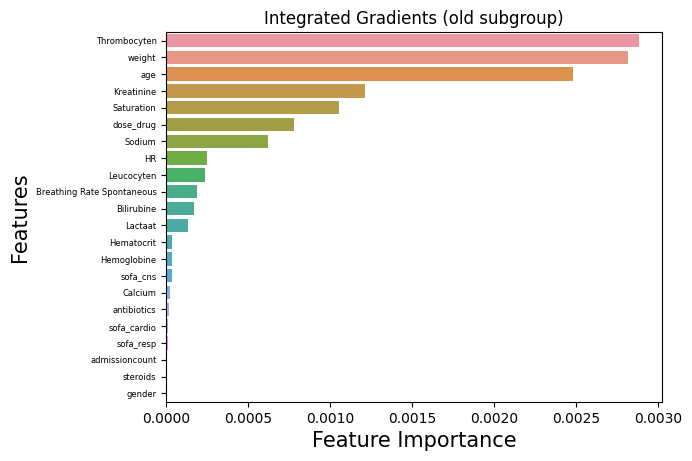

In [ ]:
X_test_old.requires_grad_()

# use mean for features as baseline
baseline = torch.mean(X_test_old, dim=(0, 1), keepdim=True)

attr = ig.attribute(X_test_old, baseline, target=1, return_convergence_delta=False)
attr = attr.detach().numpy()
attr_flat = attr.reshape(-1,22)
importances = np.mean(attr_flat, axis=0)

visualize_feature_importances(feature_names, importances)

lstm_df =  pd.DataFrame(importances, columns = ['Feature Importance'])
lstm_df['Features'] = feature_names
lstm_df = lstm_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

# absolute
lstm_df['abs'] = abs(lstm_df['Feature Importance'])
lstm_df = lstm_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
ax = sns.barplot(x='abs', y='Features', data=lstm_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('Integrated Gradients (old subgroup)')
plt.savefig('LSTM_feature_importance_absolute.png', dpi = 300, bbox_inches='tight')

with steroid

LSTM Average Feature Importances
steroids :  -0.000
antibiotics :  0.000
admissioncount :  -0.000
gender :  -0.000
age :  -0.002
weight :  0.003
sofa_resp :  -0.000
sofa_cns :  0.000
sofa_cardio :  -0.000
dose_drug :  -0.001
Hematocrit :  0.000
Hemoglobine :  0.000
Leucocyten :  -0.000
Thrombocyten :  0.003
Bilirubine :  -0.000
Kreatinine :  -0.001
Lactaat :  -0.000
Breathing Rate Spontaneous :  0.000
Sodium :  0.001
Calcium :  -0.000
HR :  0.000
Saturation :  0.001


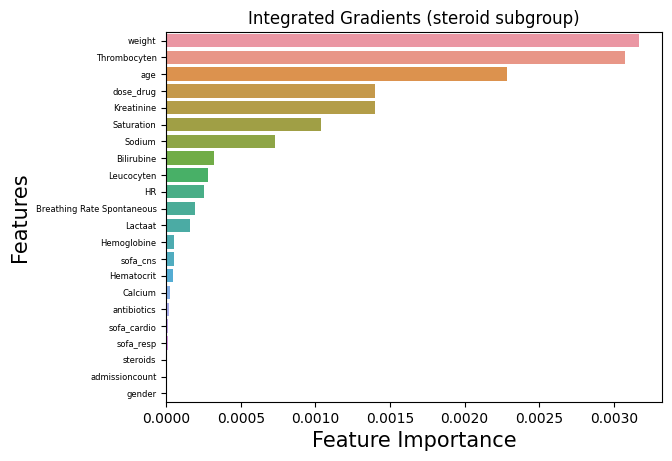

In [ ]:
X_test_steroid.requires_grad_()

# use mean for features as baseline
baseline = torch.mean(X_test_steroid, dim=(0, 1), keepdim=True)

attr = ig.attribute(X_test_steroid, baseline, target=1, return_convergence_delta=False)
attr = attr.detach().numpy()
attr_flat = attr.reshape(-1,22)
importances = np.mean(attr_flat, axis=0)

visualize_feature_importances(feature_names, importances)

lstm_df =  pd.DataFrame(importances, columns = ['Feature Importance'])
lstm_df['Features'] = feature_names
lstm_df = lstm_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

# absolute
lstm_df['abs'] = abs(lstm_df['Feature Importance'])
lstm_df = lstm_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
ax = sns.barplot(x='abs', y='Features', data=lstm_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('Integrated Gradients (steroid subgroup)')
plt.savefig('LSTM_feature_importance_absolute.png', dpi = 300, bbox_inches='tight')

no steroid

LSTM Average Feature Importances
steroids :  0.000
antibiotics :  0.000
admissioncount :  -0.000
gender :  -0.000
age :  -0.001
weight :  0.002
sofa_resp :  -0.000
sofa_cns :  0.000
sofa_cardio :  -0.000
dose_drug :  0.000
Hematocrit :  0.000
Hemoglobine :  0.000
Leucocyten :  -0.000
Thrombocyten :  0.002
Bilirubine :  -0.000
Kreatinine :  -0.001
Lactaat :  -0.000
Breathing Rate Spontaneous :  0.000
Sodium :  0.000
Calcium :  -0.000
HR :  0.000
Saturation :  0.001


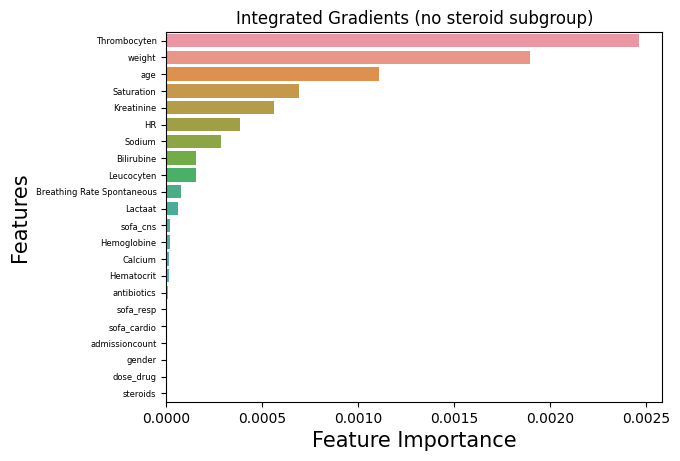

In [ ]:
X_test_nosteroid.requires_grad_()

# use mean for features as baseline
baseline = torch.mean(X_test_nosteroid, dim=(0, 1), keepdim=True)

attr = ig.attribute(X_test_nosteroid, baseline, target=1, return_convergence_delta=False)
attr = attr.detach().numpy()
attr_flat = attr.reshape(-1,22)
importances = np.mean(attr_flat, axis=0)

visualize_feature_importances(feature_names, importances)

lstm_df =  pd.DataFrame(importances, columns = ['Feature Importance'])
lstm_df['Features'] = feature_names
lstm_df = lstm_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

# absolute
lstm_df['abs'] = abs(lstm_df['Feature Importance'])
lstm_df = lstm_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
ax = sns.barplot(x='abs', y='Features', data=lstm_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('Integrated Gradients (no steroid subgroup)')
plt.savefig('LSTM_feature_importance_absolute.png', dpi = 300, bbox_inches='tight')

high sofa

LSTM Average Feature Importances
steroids :  -0.000
antibiotics :  0.000
admissioncount :  -0.000
gender :  0.000
age :  -0.002
weight :  0.003
sofa_resp :  -0.000
sofa_cns :  0.000
sofa_cardio :  -0.000
dose_drug :  -0.001
Hematocrit :  0.000
Hemoglobine :  0.000
Leucocyten :  -0.000
Thrombocyten :  0.003
Bilirubine :  -0.000
Kreatinine :  -0.001
Lactaat :  -0.000
Breathing Rate Spontaneous :  0.000
Sodium :  0.000
Calcium :  -0.000
HR :  0.000
Saturation :  0.001


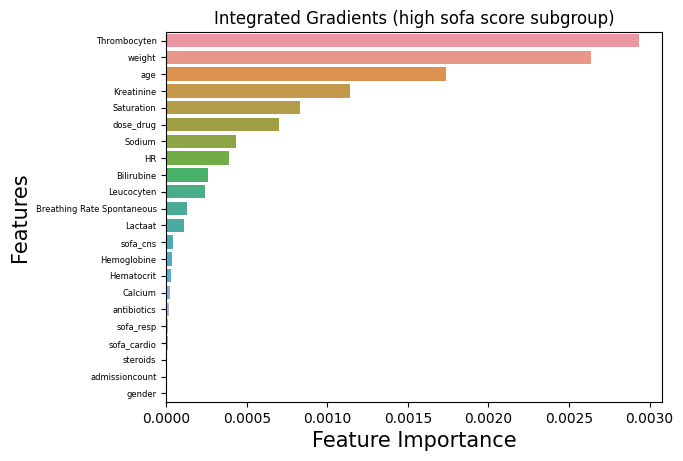

In [ ]:
X_test_highsofa.requires_grad_()

# use mean for features as baseline
baseline = torch.mean(X_test_highsofa, dim=(0, 1), keepdim=True)

attr = ig.attribute(X_test_highsofa, baseline, target=1, return_convergence_delta=False)
attr = attr.detach().numpy()
attr_flat = attr.reshape(-1,22)
importances = np.mean(attr_flat, axis=0)

visualize_feature_importances(feature_names, importances)

lstm_df =  pd.DataFrame(importances, columns = ['Feature Importance'])
lstm_df['Features'] = feature_names
lstm_df = lstm_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

# absolute
lstm_df['abs'] = abs(lstm_df['Feature Importance'])
lstm_df = lstm_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
ax = sns.barplot(x='abs', y='Features', data=lstm_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('Integrated Gradients (high sofa score subgroup)')
plt.savefig('LSTM_feature_importance_absolute.png', dpi = 300, bbox_inches='tight')

low sofa

LSTM Average Feature Importances
steroids :  -0.000
antibiotics :  0.000
admissioncount :  -0.000
gender :  0.000
age :  -0.001
weight :  0.002
sofa_resp :  -0.000
sofa_cns :  0.000
sofa_cardio :  -0.000
dose_drug :  -0.000
Hematocrit :  0.000
Hemoglobine :  0.000
Leucocyten :  -0.000
Thrombocyten :  0.003
Bilirubine :  -0.000
Kreatinine :  -0.001
Lactaat :  -0.000
Breathing Rate Spontaneous :  0.000
Sodium :  0.000
Calcium :  -0.000
HR :  0.000
Saturation :  0.001


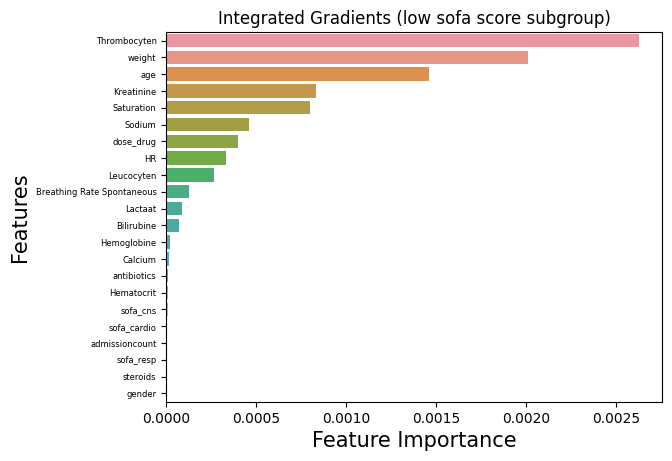

In [ ]:
X_test_lowsofa.requires_grad_()

# use mean for features as baseline
baseline = torch.mean(X_test_lowsofa, dim=(0, 1), keepdim=True)

attr = ig.attribute(X_test_lowsofa, baseline, target=1, return_convergence_delta=False)
attr = attr.detach().numpy()
attr_flat = attr.reshape(-1,22)
importances = np.mean(attr_flat, axis=0)

visualize_feature_importances(feature_names, importances)

lstm_df =  pd.DataFrame(importances, columns = ['Feature Importance'])
lstm_df['Features'] = feature_names
lstm_df = lstm_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

# absolute
lstm_df['abs'] = abs(lstm_df['Feature Importance'])
lstm_df = lstm_df.sort_values(by = ['abs'], ascending = False, ignore_index = True)
ax = sns.barplot(x='abs', y='Features', data=lstm_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('Integrated Gradients (low sofa score subgroup)')
plt.savefig('LSTM_feature_importance_absolute.png', dpi = 300, bbox_inches='tight')

## timeshap

In [ ]:
model_wrapped = TorchModelWrapper(pytorch_model)
f_hs = lambda x, y=None: model_wrapped.predict_last_hs(x, y)

In [ ]:
train_features = ['steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation']

In [ ]:
test_id_timeshap = np.sort(id_test)

In [ ]:
correct_id = [sorted(id_test)[i] for i in correct_indices.tolist()]
len(correct_id)

235

In [ ]:
incorrect_id = [sorted(id_test)[i] for i in incorrect_indices.tolist()]
len(incorrect_id)

46

In [ ]:
set(young_id) & set(nosteroid_id) & set(lowsofa_id) & set(correct_id)

{5695}

In [ ]:
set(old_id) & set(steroid_id) & set(highsofa_id) & set(correct_id)

{223,
 559,
 2982,
 3390,
 3520,
 4886,
 5170,
 7726,
 10193,
 10260,
 12319,
 12510,
 12751,
 12873,
 12963,
 13095,
 13761,
 14631,
 16028,
 16227,
 16552,
 16827,
 17669,
 20682,
 21597,
 21808,
 21828,
 22673,
 22924}

In [ ]:
set(old_id) & set(steroid_id) & set(highsofa_id) & set(incorrect_id)

{229,
 867,
 1679,
 1947,
 5894,
 6233,
 8814,
 9020,
 11690,
 11729,
 15204,
 18294,
 21777}

In [ ]:
test_df_timeshap = X_test.reshape(-1,22)
print(test_df_timeshap.shape)
test_df_timeshap = pd.DataFrame(test_df_timeshap.detach().numpy(), columns = train_features)
#admissionid
replicated_ids = [id for id in test_id_timeshap for _ in range(90)]
test_df_timeshap.insert(0, 'admissionid', replicated_ids)
test_df_timeshap

torch.Size([25290, 22])


,admissionid,steroids,antibiotics,admissioncount,gender,age,weight,sofa_resp,sofa_cns,sofa_cardio,...,Leucocyten,Thrombocyten,Bilirubine,Kreatinine,Lactaat,Breathing Rate Spontaneous,Sodium,Calcium,HR,Saturation
0,223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25285,23514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
25286,23514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
25287,23514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
25288,23514,0.0,0.0,2.0,0.0,50.0,0.0,0.0,18.0,0.0,...,12.3,3.0,23.0,70.0,25.200001,0.0,139.0,4.0,111.0,95.0


### correct prediction

baseline event

In [ ]:
test_baseline_event = test[test['admissionid'].isin(correct_id)]

In [ ]:
from timeshap.utils import calc_avg_event
average_event = calc_avg_event(test_baseline_event,
                numerical_feats=['steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation'],
                categorical_feats=[],
                model_features=['steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation'])

In [ ]:
average_event

,steroids,antibiotics,admissioncount,gender,age,weight,sofa_resp,sofa_cns,sofa_cardio,dose_drug,...,Leucocyten,Thrombocyten,Bilirubine,Kreatinine,Lactaat,Breathing Rate Spontaneous,Sodium,Calcium,HR,Saturation
0,0.0,1.0,1.0,0.0,60.0,70.0,0.0,18.0,0.0,0.0,...,13.4,204.0,9.0,91.0,1.4,16.0,141.0,4.1,89.0,98.0


baseline sequence

In [ ]:
test_baseline_sequence = test_df_timeshap[test_df_timeshap['admissionid'].isin(correct_id)]

In [ ]:
from timeshap.utils import calc_avg_sequence
average_sequence = calc_avg_sequence(test_baseline_sequence, numerical_feats=['steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation'],
                categorical_feats=[],
                model_features=['steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation'], entity_col='admissionid')

average score over baseline

In [ ]:
import copy
def get_avg_score_with_avg_event(model, med, top: int = 1000):
    avg_score = {}
    expanded = np.expand_dims(med, axis=0)
    for x in range(1, top+1):
        expanded_copy = copy.deepcopy(expanded)
        tiled_background = np.tile(expanded_copy, (1, x, 1))
        print
        pred = model(tiled_background)
        avg_score[x] = round(float(pred), 6)
    return avg_score

In [ ]:
avg_score_over_len = get_avg_score_with_avg_event(f_hs, average_event.T, top=90)

Local Report

In [ ]:
positive_correct_id = 5695
pos_x_pd = test_baseline_sequence[test_baseline_sequence['admissionid'] == positive_correct_id]

pos_x_data = pos_x_pd[train_features]
# convert the instance to numpy so TimeSHAP receives it
pos_x_data = np.expand_dims(pos_x_data.to_numpy().copy(), axis=0)

In [ ]:
plot_feats = {key: key for key in train_features}

In [ ]:
import shap
from timeshap.explainer import local_report
# change father class in source code from 'Kernel' to 'KernelExplainer'

pruning_dict = {'tol': 0.025}
event_dict = {'rs': 42, 'nsamples': 281}
feature_dict = {'rs': 42, 'nsamples': 281, 'feature_names': train_features, 'plot_features': plot_feats}
cell_dict = {'rs': 42, 'nsamples': 281, 'top_x_feats': 2, 'top_x_events': 2}
local_report(f_hs, pos_x_data, pruning_dict, event_dict, feature_dict, cell_dict, average_event, entity_uuid=positive_correct_id, entity_col='admissionid')

Assuming all features are model features
Unable to prune sequence.


alt.HConcatChart(...)

In [ ]:
negative_correct_id = 5170
pos_x_pd = test_baseline_sequence[test_baseline_sequence['admissionid'] == negative_correct_id]

pos_x_data = pos_x_pd[train_features]
# convert the instance to numpy so TimeSHAP receives it
pos_x_data = np.expand_dims(pos_x_data.to_numpy().copy(), axis=0)

In [ ]:
import shap
from timeshap.explainer import local_report
# change father class in source code from 'Kernel' to 'KernelExplainer'

pruning_dict = {'tol': 0.025}
event_dict = {'rs': 42, 'nsamples': 281}
feature_dict = {'rs': 42, 'nsamples': 281, 'feature_names': train_features, 'plot_features': plot_feats}
cell_dict = {'rs': 42, 'nsamples': 281, 'top_x_feats': 2, 'top_x_events': 2}
local_report(f_hs, pos_x_data, pruning_dict, event_dict, feature_dict, cell_dict, average_event, entity_uuid=positive_correct_id, entity_col='admissionid')

Assuming all features are model features


alt.HConcatChart(...)

### incorrect prediction

In [ ]:
test_baseline_event = test[test['admissionid'].isin(incorrect_id)]

In [ ]:
from timeshap.utils import calc_avg_event
average_event = calc_avg_event(test_baseline_event,
                numerical_feats=['steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation'],
                categorical_feats=[],
                model_features=['steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation'])

In [ ]:
average_event

,steroids,antibiotics,admissioncount,gender,age,weight,sofa_resp,sofa_cns,sofa_cardio,dose_drug,...,Leucocyten,Thrombocyten,Bilirubine,Kreatinine,Lactaat,Breathing Rate Spontaneous,Sodium,Calcium,HR,Saturation
0,0.0,1.0,1.0,0.0,60.0,70.0,0.0,18.0,0.0,0.0,...,13.7,153.0,14.0,123.0,1.5,18.0,143.0,4.2,91.0,98.0


In [ ]:
test_baseline_sequence = test_df_timeshap[test_df_timeshap['admissionid'].isin(incorrect_id)]

In [ ]:
from timeshap.utils import calc_avg_sequence
average_sequence = calc_avg_sequence(test_baseline_sequence, numerical_feats=['steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation'],
                categorical_feats=[],
                model_features=['steroids', 'antibiotics', 'admissioncount',
       'gender', 'age', 'weight', 'sofa_resp', 'sofa_cns', 'sofa_cardio',
       'dose_drug', 'Hematocrit', 'Hemoglobine',
       'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine', 'Lactaat',
       'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR', 'Saturation'], entity_col='admissionid')

In [ ]:
avg_score_over_len = get_avg_score_with_avg_event(f_hs, average_event.T, top=90)

In [ ]:
positive_incorrect_id = 5894
pos_x_pd = test_baseline_sequence[test_baseline_sequence['admissionid'] == positive_incorrect_id]

pos_x_data = pos_x_pd[train_features]
# convert the instance to numpy so TimeSHAP receives it
pos_x_data = np.expand_dims(pos_x_data.to_numpy().copy(), axis=0)

In [ ]:
import shap
from timeshap.explainer import local_report

pruning_dict = {'tol': 0.025}
event_dict = {'rs': 42, 'nsamples': 281}
feature_dict = {'rs': 42, 'nsamples': 281, 'feature_names': train_features, 'plot_features': plot_feats}
cell_dict = {'rs': 42, 'nsamples': 281, 'top_x_feats': 2, 'top_x_events': 2}
local_report(f_hs, pos_x_data, pruning_dict, event_dict, feature_dict, cell_dict, average_event, entity_uuid=positive_incorrect_id, entity_col='admissionid')

Assuming all features are model features


alt.HConcatChart(...)

## surrogate model
use the output of the LSTM layer or the hidden states as features for surrogate model

In [ ]:
y_test_labels = predicted_labels_at_selected_threshold

# Create a decision tree classifier
decision_tree = DecisionTreeClassifier(max_depth=5)
decision_tree.fit(X_test.detach().numpy().reshape(-1,90*22), y_test_labels)

# Make predictions on the validation set
# predictions = decision_tree.predict(X_test[:,-1,:])

# Evaluate the accuracy
# accuracy = accuracy_score(y_test_labels, predictions)
# print(f"Surrogate Decision Tree Accuracy: {accuracy}")

DecisionTreeClassifier(max_depth=5)

In [ ]:
# reshape to timestamps x features
feature_importances = decision_tree.feature_importances_
print(feature_importances.shape)
feature_importance_aggregate = np.reshape(feature_importances,(90,22))
feature_importance_aggregate = feature_importance_aggregate.sum(axis = 0)

print(feature_importance_aggregate)
print(feature_importance_aggregate.shape)

(1980,)
[0.         0.         0.         0.         0.07333942 0.02089465
 0.         0.         0.         0.27126036 0.01471298 0.01018591
 0.         0.11636903 0.0781542  0.18167636 0.09931397 0.
 0.04413894 0.08995418 0.         0.        ]
(22,)


In [ ]:
feature_importance_aggregate.sum()

0.9999999999999998

In [ ]:
variables = ['steroids', 'antibiotics', 'admissioncount', 'gender', 'age', 'weight',
       'sofa_resp', 'sofa_cns', 'sofa_cardio', 'dose_drug', 'Hematocrit',
       'Hemoglobine', 'Leucocyten', 'Thrombocyten', 'Bilirubine', 'Kreatinine',
       'Lactaat', 'Breathing Rate Spontaneous', 'Sodium', 'Calcium', 'HR',
       'Saturation']

In [ ]:
tree_df =  pd.DataFrame(feature_importance_aggregate, columns = ['Feature Importance'])
tree_df['Features'] = variables
tree_df = tree_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

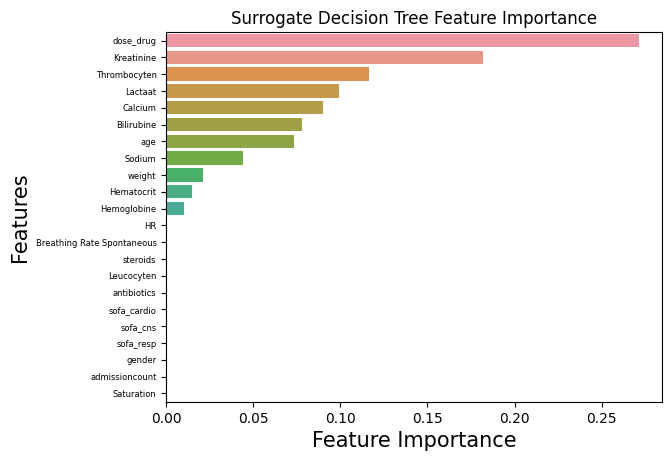

In [ ]:
import seaborn as sns
ax = sns.barplot(x='Feature Importance', y='Features', data=tree_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('Surrogate Decision Tree Feature Importance')
plt.savefig('DT_feature_importance.png', dpi = 300, bbox_inches='tight')